In [1]:
!pip install tensorflow

# Generative Adversarial Network (GAN) for MNIST
This program builds and trains a Generative Adversarial Network to create images of handwritten digits that resemble the MNIST dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time # To track time per epoch

# --- 1. Data Loading and Preprocessing ---
def load_data():
    (x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    # Normalize images to the range [-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    # Add a channel dimension
    x_train = np.expand_dims(x_train, axis=-1)
    # Create a TensorFlow Dataset
    return tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128).prefetch(tf.data.AUTOTUNE)

# --- 2. Model Architectures ---
def build_generator():
    """Builds the Generator model that creates images from random noise."""
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model

def build_discriminator():
    """Builds the Discriminator model that classifies images as real or fake."""
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# --- 3. Optimizers and Loss Function ---
def get_optimizers():
    """Returns Adam optimizers for both models."""
    return tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.Adam(1e-4)

# Binary Crossentropy is used to classify real vs. fake images.
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# --- 4. Training Step ---
# Compile the training step into a TensorFlow graph for performance
@tf.function
def train_step(images, generator, discriminator, g_opt, d_opt):
    """Executes a single training step for the GAN."""
    # Generate random noise for the generator input
    noise = tf.random.normal([128, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Generator loss: tries to make the discriminator predict 1 (real) for fake images
        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)

        # Discriminator loss: tries to predict 1 for real images and 0 for fake images
        disc_loss = (loss_fn(tf.ones_like(real_output), real_output) +
                     loss_fn(tf.zeros_like(fake_output), fake_output))

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to update model weights
    g_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# --- 5. MODIFIED Training Loop and Visualization ---
def train(dataset, epochs, generator, discriminator, g_opt, d_opt):
    """The main training loop with progress updates inside each epoch."""
    for epoch in range(epochs):
        start_time = time.time()
        # Enumerate the dataset to get the batch index
        for i, batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(batch, generator, discriminator, g_opt, d_opt)

            # MODIFICATION: Print progress every 100 batches
            if (i + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}, Batch {i+1}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")

        # A clear message at the end of each epoch
        epoch_time = time.time() - start_time
        print(f"--- End of Epoch {epoch+1} (took {epoch_time:.2f}s) ---")
        # Generate a sample image to see progress
        generate_and_show(generator, epoch)


def generate_and_show(generator, epoch=None):
    """Generates and displays a grid of images from the generator."""
    noise = tf.random.normal([16, 100])
    images = generator(noise, training=False)
    # Rescale images from [-1, 1] to [0, 1] for display
    images = (images + 1) / 2

    fig, axes = plt.subplots(4, 4, figsize=(4, 4))

    # Add a title to the figure if an epoch number is provided
    if epoch is not None:
        fig.suptitle(f'Images after Epoch {epoch+1}', fontsize=16)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, 0], cmap='gray')
        ax.axis('off')

    plt.show()

# --- 6. Execution ---
mnist_data = load_data()
generator = build_generator()
discriminator = build_discriminator()
g_opt, d_opt = get_optimizers()

train(mnist_data, epochs=30, generator=generator, discriminator=discriminator, g_opt=g_opt, d_opt=d_opt)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, 

  Epoch 1, Batch 100, Gen Loss: 0.6032, Disc Loss: 1.2234


# CNN Regularization Techniques Comparison
This program trains four different Convolutional Neural Network models on the MNIST dataset to compare the effects of using no regularization, Batch Normalization, Dropout, and both techniques combined. Finally, it plots their validation accuracies.


Training Standard CNN...




Training CNN with Batch Normalization...

Training CNN with Dropout...
Training CNN with BatchNorm and Dropout...


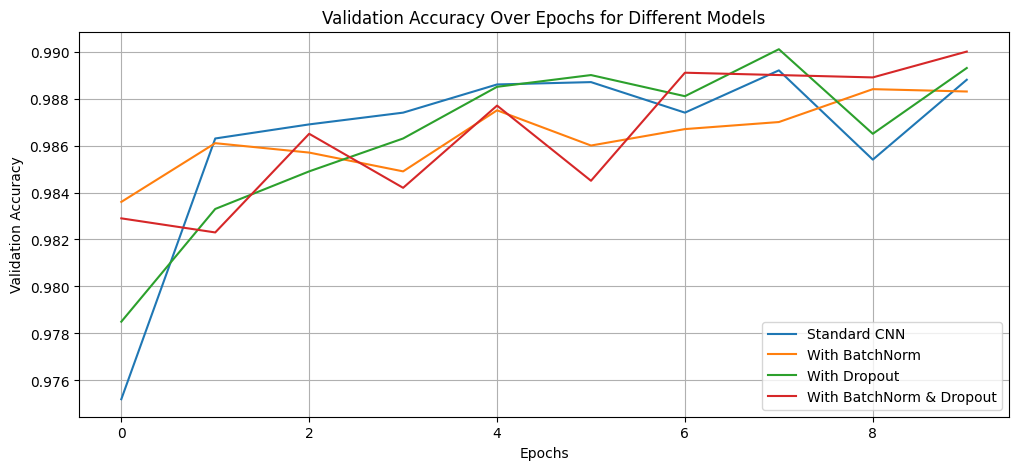

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Data Loading and Preprocessing ---
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to range [0, 1]
X_train, X_test = X_train / 255.0, X_test / 255.0

# Reshape to match CNN input (batch_size, height, width, channels)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# --- 2. Model Definitions ---

# Model 1: Standard CNN without regularization
def create_cnn_with_strides():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', strides=2, input_shape=(28,28,1)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 2: CNN with Batch Normalization
def create_batchnorm_cnn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', strides=2, input_shape=(28,28,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 3: CNN with Dropout
def create_dropout_cnn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', strides=2, input_shape=(28,28,1)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5), # 50% of neurons are randomly deactivated
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 4: CNN with both Batch Normalization and Dropout
def create_batchnorm_dropout_cnn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', strides=2, input_shape=(28,28,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5), # 50% dropout to prevent overfitting
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- 3. Training the Models ---
print("Training Standard CNN...")
cnn_model = create_cnn_with_strides()
cnn_history = cnn_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=64, verbose=0)

print("Training CNN with Batch Normalization...")
batchnorm_cnn = create_batchnorm_cnn()
batchnorm_history = batchnorm_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=64, verbose=0)

print("Training CNN with Dropout...")
dropout_cnn = create_dropout_cnn()
dropout_history = dropout_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=64, verbose=0)

print("Training CNN with BatchNorm and Dropout...")
batchnorm_dropout_cnn = create_batchnorm_dropout_cnn()
batchnorm_dropout_history = batchnorm_dropout_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=64, verbose=0)

# --- 4. Plotting Results ---
def plot_training_results(histories, labels):
    plt.figure(figsize=(12, 5))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=f"{labels[i]}")
    plt.title("Validation Accuracy Over Epochs for Different Models")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_results(
    (cnn_history, batchnorm_history, dropout_history, batchnorm_dropout_history),
    ("Standard CNN", "With BatchNorm", "With Dropout", "With BatchNorm & Dropout")
)

# MLOps - Experiment Tracking (WandB) & Model Explainability (SHAP)
* This section contains two separate programs demonstrating common MLOps practices. The first integrates Weights and Biases (WandB) to track a CNN's training on MNIST. The second uses the SHAP library to explain the predictions of a regression model on the California Housing dataset.

* 3.1: WandB for Experiment Tracking

In [4]:
import wandb
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from wandb.integration.keras import WandbMetricsLogger
import time

# --- 1. Initialize WandB ---
# Generate a unique project name for each run using a timestamp
project_name = f"mnist-execution-{int(time.time())}"
group_name = "cnn-regularization-comparison"

# Configuration for the experiment
config = {
    "epochs": 10,
    "batch_size": 128,
    "optimizer": "adam"
}
wandb.init(project=project_name, group=group_name, config=config)

# --- 2. Load and Preprocess Data ---
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# --- 3. Define and Train the Model ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# The WandbMetricsLogger callback automatically logs metrics and losses
history = model.fit(x_train, y_train,
                    epochs=wandb.config.epochs,
                    batch_size=wandb.config.batch_size,
                    validation_split=0.2,
                    callbacks=[WandbMetricsLogger()])

# --- 4. Evaluate and Finish ---
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# Mark the run as finished
wandb.finish()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:


Abort: 

* 3.2: SHAP for Model Explainability

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6160 - mae: 0.8322
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4363 - mae: 0.4662
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3908 - mae: 0.4427
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3720 - mae: 0.4268
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3526 - mae: 0.4173
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3452 - mae: 0.4124
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4519 - mae: 0.4100
Epoch 8/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3570 - mae: 0.4001
Epoch 9/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3186 - mae: 0.3956
Epoch 10/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2998 - mae: 0.3811
Epoch 11/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3090 - mae: 0.3850
Epoch 12/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2970 - mae: 0.3766
Epoch 13/20
516/516 ━━━━━━━━━━━━━━━━

ExactExplainer explainer: 4129it [01:50, 35.82it/s]


Displaying SHAP summary plot...


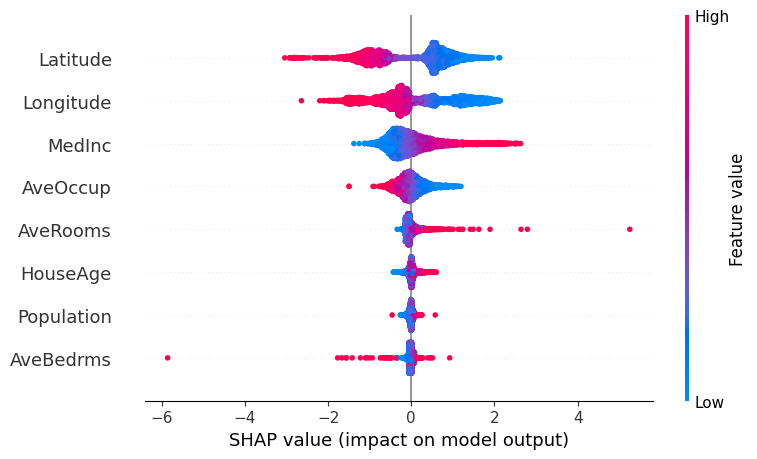

In [5]:
import shap
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 1. Load and Preprocess Data ---
data = fetch_california_housing()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 2. Build and Train a Regression Model ---
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # Linear output for regression
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# --- 3. Use SHAP to Explain Predictions ---
# SHAP needs a model and a background dataset to compute explanations
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# --- 4. Visualize Explanations ---
# The summary plot shows the impact of each feature on the model's output
print("Displaying SHAP summary plot...")
shap.summary_plot(shap_values, X_test, feature_names=data.feature_names)

# Central Limit Theorem (CLT) Simulations
This group contains two scripts that visually demonstrate the Central Limit Theorem. The first simulates thousands of coin flip experiments, and the second plots the theoretical probabilities of the sum of two dice rolls. Both distributions approximate a normal (bell) curve.

* 4.1: Coin Flip Simulation

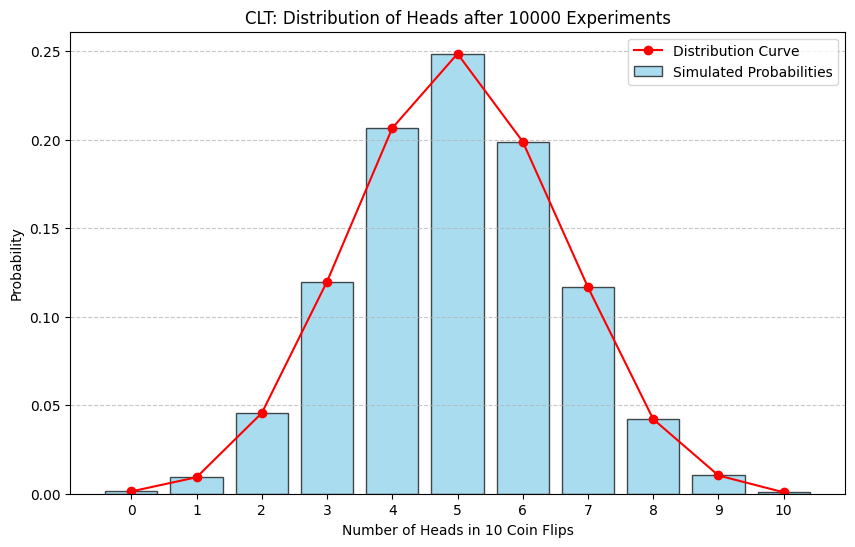

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- Simulation Parameters ---
n_flips_per_experiment = 10
num_experiments = 10000

# --- Run Simulation ---
# Store the number of heads from each experiment
results = []
for _ in range(num_experiments):
    flips = np.random.choice([0, 1], size=n_flips_per_experiment, p=[0.5, 0.5]) # 0=Tails, 1=Heads
    num_heads = np.sum(flips)
    results.append(num_heads)

# --- Calculate Probabilities ---
values, counts = np.unique(results, return_counts=True)
probabilities = counts / num_experiments

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.bar(values, probabilities, color='skyblue', edgecolor='black', alpha=0.7, label="Simulated Probabilities")
plt.plot(values, probabilities, 'o-', color='red', label="Distribution Curve")
plt.xlabel(f"Number of Heads in {n_flips_per_experiment} Coin Flips")
plt.ylabel("Probability")
plt.title(f"CLT: Distribution of Heads after {num_experiments} Experiments")
plt.xticks(np.arange(0, n_flips_per_experiment + 1, 1))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

* 4.2: Two-Dice Roll Theoretical Distribution

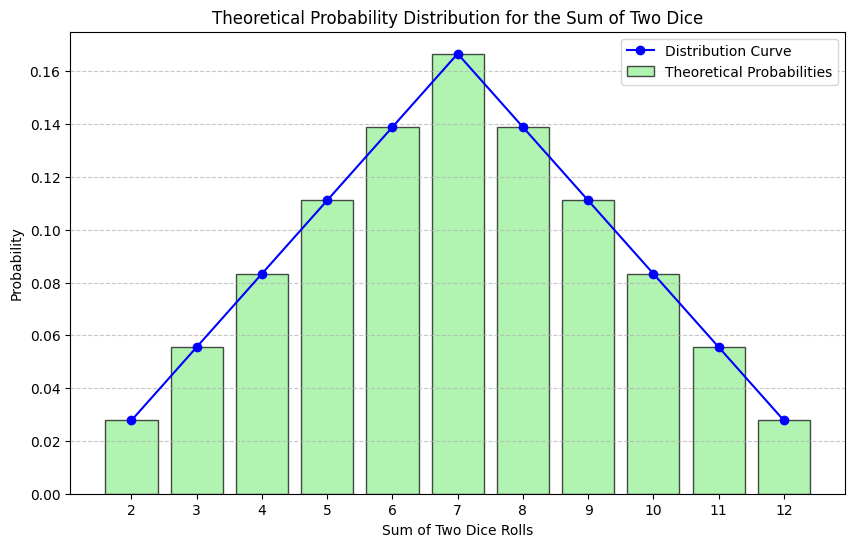

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Define Theoretical Probabilities ---
# Possible sums range from 2 to 12
values = np.arange(2, 13)

# Probabilities for each sum (e.g., P(Sum=2) = 1/36, P(Sum=7) = 6/36)
probabilities = np.array([
    1/36, 2/36, 3/36, 4/36, 5/36, 6/36, 5/36, 4/36, 3/36, 2/36, 1/36
])

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.bar(values, probabilities, color='lightgreen', edgecolor='black', alpha=0.7, label="Theoretical Probabilities")
plt.plot(values, probabilities, 'o-', color='blue', label="Distribution Curve")
plt.xlabel("Sum of Two Dice Rolls")
plt.ylabel("Probability")
plt.title("Theoretical Probability Distribution for the Sum of Two Dice")
plt.xticks(values)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualizing Training with TensorBoard
This program demonstrates how to use the TensorBoard callback in Keras to log and compare the training performance of a model using two different optimizers: Adam and SGD.

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- 1. Load Data ---
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# --- 2. Define a Reusable Model Creation Function ---
def create_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# --- 3. Train with Adam Optimizer ---
model_adam = create_model()
model_adam.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Create a TensorBoard callback for the Adam run
tb_callback_adam = tf.keras.callbacks.TensorBoard(log_dir='./logs/adam', histogram_freq=1)

print("\nTraining with Adam Optimizer...")
model_adam.fit(x_train, y_train, epochs=5, callbacks=[tb_callback_adam])


# --- 4. Train with SGD Optimizer ---
model_sgd = create_model()
model_sgd.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Create a TensorBoard callback for the SGD run
tb_callback_sgd = tf.keras.callbacks.TensorBoard(log_dir='./logs/sgd', histogram_freq=1)

print("\nTraining with SGD Optimizer...")
model_sgd.fit(x_train, y_train, epochs=5, callbacks=[tb_callback_sgd])

print("\nTraining complete. To view TensorBoard, run the following command in your terminal:")
print("tensorboard --logdir logs")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training with Adam Optimizer...
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8772 - loss: 0.4288
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9642 - loss: 0.1226
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9779 - loss: 0.0752
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9835 - loss: 0.0561
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9869 - loss: 0.0440

Training with SGD Optimizer...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7289 - loss: 1.0456
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9027 - loss: 0.3552
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9169 - loss: 0.2977
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9256 - loss: 0.2614
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9334 - loss: 0.2397

Training complete. To view TensorBoard, run the following command in your terminal:
tensorboard --logdir logs


# Advanced Keras - Custom Components and Functional API
This section provides examples of more advanced Keras features, including building models with the Functional API, creating custom layers with Lambda, and defining custom loss functions.

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model

# --- 1. Functional API Example ---
print("--- Functional API Model ---")
# Define the input layer with a specific shape
inputs = Input(shape=(784,))
# Stack layers, connecting them explicitly
hidden1 = Dense(128, activation="relu")(inputs)
hidden2 = Dense(64, activation="relu")(hidden1)
outputs = Dense(10, activation="softmax")(hidden2)
# Create the model by specifying inputs and outputs
functional_model = Model(inputs=inputs, outputs=outputs)
functional_model.summary()


# --- 2. Lambda Layer Examples ---
print("\n--- Lambda Layer Examples ---")
# Example 2a: Simple lambda function to square the input
input_simple = Input(shape=(1,))
squared_output = Lambda(lambda x: x**2)(input_simple)
lambda_model_simple = Model(inputs=input_simple, outputs=squared_output)
lambda_model_simple.summary()

# Example 2b: Using a more complex, predefined function
def custom_math_function(x):
    return tf.math.log(x) * tf.sin(x)

input_complex = Input(shape=(1,))
transformed_output = Lambda(custom_math_function)(input_complex)
lambda_model_complex = Model(inputs=input_complex, outputs=transformed_output)
lambda_model_complex.summary()


# --- 3. Custom Loss Function Examples ---
print("\n--- Custom Loss Function Examples ---")
# Example 3a: Defining loss as a standard Python function
def custom_penalty_loss(y_true, y_pred):
    # Standard categorical cross-entropy
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    # Add a custom penalty (e.g., mean squared error)
    penalty = 0.1 * tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    return cross_entropy + penalty

# Example 3b: Defining loss by subclassing the Loss class
class SimpleMeanSquaredError(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        squared_difference = tf.square(y_true - y_pred)
        return tf.reduce_mean(squared_difference, axis=-1)

# You would use these in model.compile(), e.g.:
# model.compile(optimizer='adam', loss=custom_penalty_loss)
# model.compile(optimizer='adam', loss=SimpleMeanSquaredError())
print("Custom loss functions 'custom_penalty_loss' and 'SimpleMeanSquaredError' are defined.")

--- Functional API Model ---


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


--- Lambda Layer Examples ---


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- Custom Loss Function Examples ---
Custom loss functions 'custom_penalty_loss' and 'SimpleMeanSquaredError' are defined.


# Inspecting Model Weights and Biases
This is a basic program that builds and trains a simple neural network on MNIST and then demonstrates how to access and print the trained parameters (weights and biases) for each dense layer.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- 1. Define and Train a Simple Model ---
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu', name='dense_1'), # Name layers for clarity
    layers.Dense(10, activation='softmax', name='output_layer')
])

# Load data
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0

# Compile and train
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Training a simple model...")
model.fit(x_train, y_train, epochs=5, verbose=1)

# --- 2. Access and Inspect Layer Parameters ---
print("\n--- Inspecting Model Parameters ---")

for layer in model.layers:
    # Check if the layer has trainable weights (e.g., Flatten does not)
    if layer.get_weights():
        print(f"\nParameters for Layer: '{layer.name}'")
        weights, biases = layer.get_weights()

        # Print shapes
        print(f"  Weights shape: {weights.shape}")
        print(f"  Biases shape:  {biases.shape}")

        # Print a small sample of the parameters
        print("  Weights (first 2x2 elements):")
        print(weights[:2, :2])
        print("  Biases (first 5 elements):")
        print(biases[:5])

Training a simple model...
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8740 - loss: 0.4404
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9648 - loss: 0.1251
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9762 - loss: 0.0808
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9831 - loss: 0.0577
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9861 - loss: 0.0444

--- Inspecting Model Parameters ---

Parameters for Layer: 'dense_1'
  Weights shape: (784, 128)
  Biases shape:  (128,)
  Weights (first 2x2 elements):
[[-0.06834329 -0.07876913]
 [-0.0512866  -0.00959696]]
  Biases (first 5 elements):
[-0.00904768 -0.00895562  0.05562103  0.04755099  0.05957031]

Parameters for Layer: 'output_layer'
  Weights shape: (128, 10)
  Biases shape:  (10,)
  Weights (first 2x2 elements):
[[-0.28934023  0.06915007]
 [-0.46913666  0.49222955]]
  Biases (first 5 elements):
[-0.12240011 -0.08822508  0.004353